In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib
import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [3]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

选取样本

In [4]:
sample_idx = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_oh_ = label_oh.cpu().numpy()
label_ls_ = label_ls.cpu().numpy()
label_svls_ = label_svls.cpu().numpy()

print(label_oh_.shape)
print(label_ls_.shape)
print(label_svls_.shape)

(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)


可视化样本

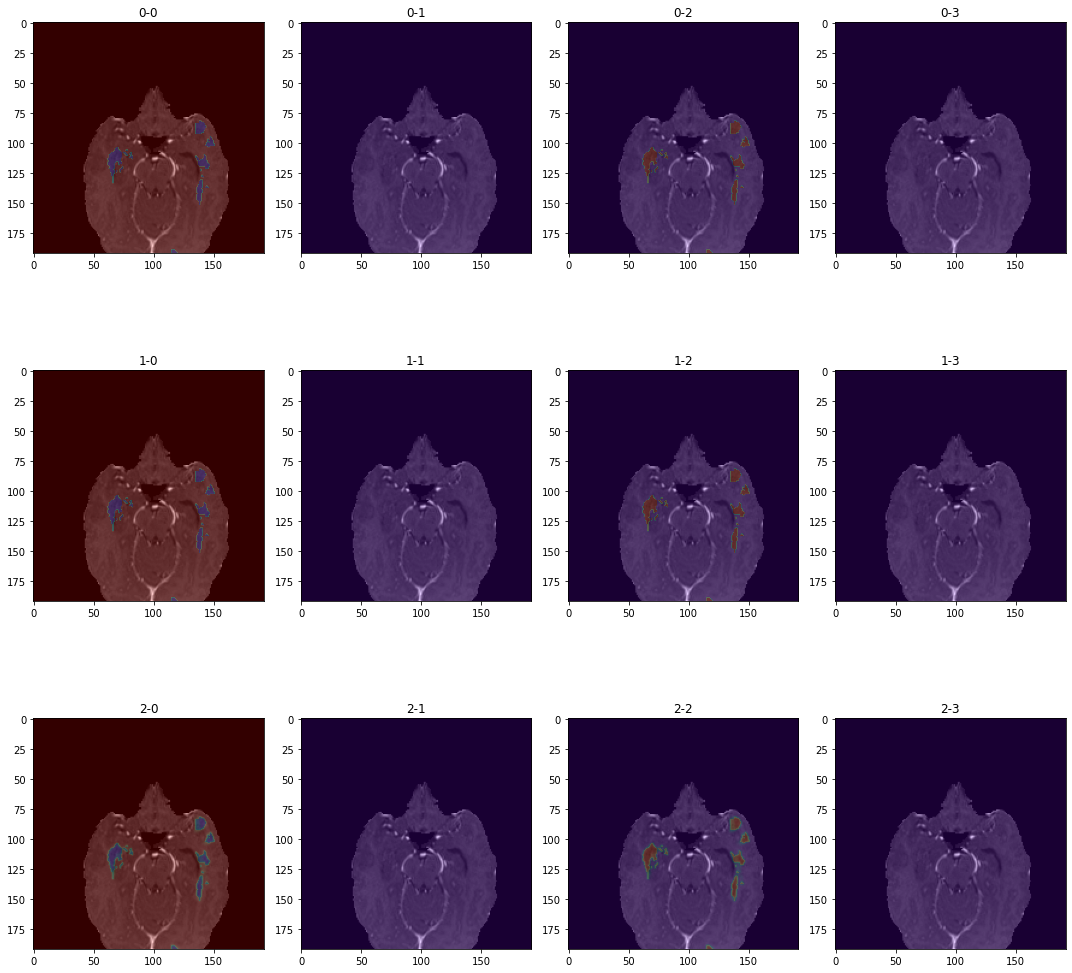

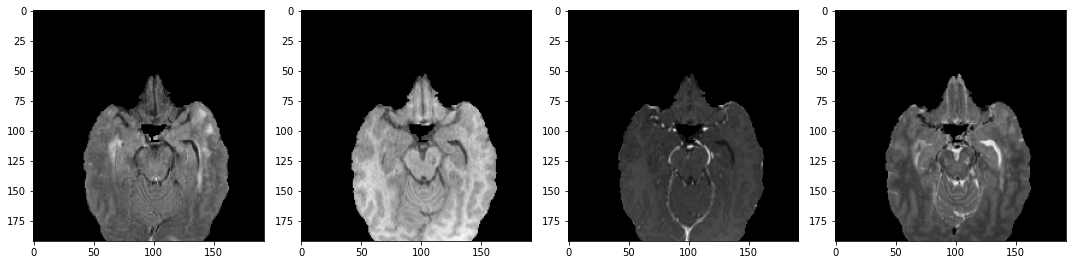

In [5]:
depth = 50

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()


image_slice = image[:, depth, ...].cpu().numpy()


figure, axs = plt.subplots(3, 4, figsize=(15, 15))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(15, 15))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.tight_layout()
plt.show()

In [16]:
import math


def get_gaussian_filter(kernel_size=3, sigma=1):
    # Create a x, y, z coordinate grid of shape (kernel_size, kernel_size, kernel_size, 3)
    x_coord = torch.arange(kernel_size)
    x_grid_2d = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    x_grid = x_coord.repeat(kernel_size*kernel_size).view(kernel_size, kernel_size, kernel_size)
    y_grid_2d = x_grid_2d.t()
    y_grid  = y_grid_2d.repeat(kernel_size,1).view(kernel_size, kernel_size, kernel_size)
    z_grid = y_grid_2d.repeat(1,kernel_size).view(kernel_size, kernel_size, kernel_size)
    xyz_grid = torch.stack([x_grid, y_grid, z_grid], dim=-1).float()
    mean = (kernel_size - 1)/2.
    variance = sigma**2.
    # Calculate the 3-dimensional gaussian kernel
    gaussian_kernel = (1./(2.*math.pi*variance + 1e-16)) * torch.exp(
                            -torch.sum((xyz_grid - mean)**2., dim=-1) / (2*variance + 1e-16))

    return gaussian_kernel

class CELossWithSVLS_VE(torch.nn.Module):
    def __init__(self, classes=None, sigma_dist=1, sigma_diff=1):
        super(CELossWithSVLS_VE, self).__init__()
        self.cls = torch.tensor(classes)
        self.cls_idx = torch.arange(self.cls).reshape(1, self.cls).cuda()
        self.dist_weight = get_gaussian_filter(sigma=sigma_dist)
        self.dist_weight = self.dist_weight[None, None, None, None, None, ...].cuda()
        self.sigma_diff = sigma_diff

    def forward(self, inputs, labels, images):
        with torch.no_grad():
            # grayscale diff weights
            image_diff = F.pad(images, (1,1,1,1,1,1), mode='replicate') \
                            .unfold(2, size=3, step=1) \
                            .unfold(3, size=3, step=1) \
                            .unfold(4, size=3, step=1) - images[..., None, None, None]
            image_diff, _ = torch.max(image_diff, dim=1, keepdim=True)  # extract the max difference
            weights = (1./(2.*math.pi*self.sigma_diff**2 + 1e-16)) * torch.exp(
                                    -image_diff**2 / (2*self.sigma_diff**2 + 1e-16))
            del image_diff
            
            # elementwise poduct to combine diff_weights and dist_weight
            weights = weights * self.dist_weight

            # Make sure sum of values in gaussian kernel equals 1 and sum_neighbors == center
            weights = weights / torch.sum(weights, dim=(-3, -2, -1), keepdim=True)
            neighbors_sum = 1 - weights[..., 1:2,1:2,1:2]
            weights[..., 1:2,1:2,1:2] = neighbors_sum
            weights = weights / neighbors_sum
            del neighbors_sum

            # get label patches
            oh_labels = (labels[...,None] == self.cls_idx).permute(0,4,1,2,3)
            b, c, d, h, w = oh_labels.shape
            oh_labels = oh_labels.view(b, c, d, h, w).repeat(1, 1, 1, 1, 1).float()
            label_oh_patches = F.pad(oh_labels, (1,1,1,1,1,1), mode='replicate') \
                                .unfold(2, size=3, step=1) \
                                .unfold(3, size=3, step=1) \
                                .unfold(4, size=3, step=1)

            # get smoothed labels
            label_svls_ve_ = label_oh_patches * weights / torch.sum(weights, dim=(-3, -2, -1), keepdim=True)
            label_svls_ve = torch.sum(label_svls_ve_, dim=(-3, -2, -1))
            del label_oh_patches, weights
        return label_svls_ve
        # return (- label_svls_ve * F.log_softmax(inputs, dim=1)).sum(dim=1).mean()

In [12]:
from svls import CELossWithSVLS

svls = CELossWithSVLS(classes=4).cuda()
svls_ve = CELossWithSVLS_VE(classes=4, sigma_dist=1.0, sigma_diff=0.05).cuda()

In [14]:
dummy = torch.rand((1, 4, 128, 192, 192)).float().cuda()

loss_svls = svls(dummy, label)

loss_svls_ve = svls_ve(dummy, label, image[None])

print(loss_svls)

print(loss_svls_ve)

print(loss_svls - loss_svls_ve)

tensor(1.4173, device='cuda:0')
tensor(1.4173, device='cuda:0')
tensor(0., device='cuda:0')


In [21]:
svls_ve = CELossWithSVLS_VE(classes=4, sigma_diff=0.1).cuda()

dummy = torch.ones((1, 4, 128, 192, 192)).float().cuda()

label_svls_ve = svls_ve(dummy, label, image[None, ...])

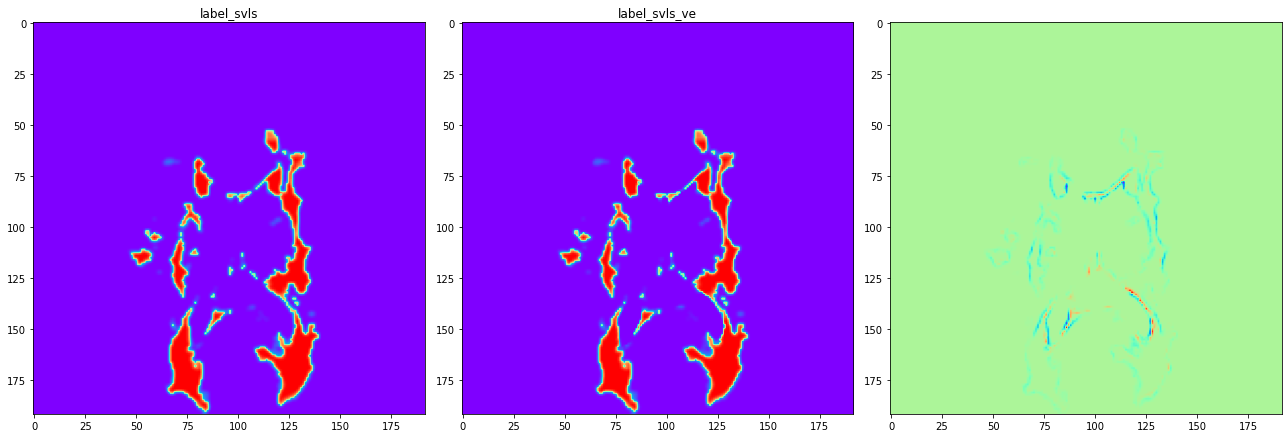

In [26]:
label_svls_ve_np = label_svls_ve.cpu().numpy()
label_svls_np = label_svls.cpu().numpy()
diff = label_svls_ve_np - label_svls_np

depth = 77

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axs.ravel()

ax1.imshow(label_svls_np[0, 2, depth], cmap='rainbow')
ax1.set_title('label_svls')
ax2.imshow(label_svls_ve_np[0, 2, depth], cmap='rainbow')
ax2.set_title('label_svls_ve')
ax3_ = ax3.imshow(diff[0, 2, depth], cmap='rainbow')
# plt.colorbar(ax3_, ax=ax3)

plt.tight_layout()
plt.show()

In [59]:
np.min(diff)

-1.6093254e-06